## Python and SQL Connection

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

 ···········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
# data = pd.read_sql_query('SELECT * FROM loan', engine)
# data.head()

## Pull data from SQL

In [3]:
query = '''select t.type, t.operation, t.amount as t_amount, 
t.balance, t.k_symbol, l.amount as l_amount, l.duration, l.payments, l.status
from trans t
left join loan l
on t.account_id = l.account_id;'''

data = pd.read_sql_query(query, engine)
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,VKLAD,700.0,700.0,,NaN,NaN,NaN,None
1,PRIJEM,VKLAD,900.0,900.0,,NaN,NaN,NaN,None
2,PRIJEM,VKLAD,1000.0,1000.0,,NaN,NaN,NaN,None
3,PRIJEM,VKLAD,600.0,600.0,,NaN,NaN,NaN,None
4,PRIJEM,VKLAD,400.0,400.0,,NaN,NaN,NaN,None


## EDA + Cleaning

### Status

In [4]:
data['status'].value_counts()

C    72288
A    64599
B     9765
D     9429
Name: status, dtype: int64

In [5]:
data.shape

(868019, 9)

In [6]:
data.dtypes

type          object
operation     object
t_amount     float64
balance      float64
k_symbol      object
l_amount     float64
duration     float64
payments     float64
status        object
dtype: object

In [7]:
data.isna().sum()

type              0
operation         0
t_amount          0
balance           0
k_symbol          0
l_amount     711938
duration     711938
payments     711938
status       711938
dtype: int64

### Duration

In [8]:
data = data[data['duration'].isna() == False]

In [9]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [10]:
data['duration'] = data['duration'].astype('object') # This will be treated as categorical
data.describe()

,t_amount,balance,l_amount,payments
count,156081.000000,156081.000000,156081.000000,156081.000000
mean,7795.357503,45353.630156,146822.230995,4189.309205
std,11707.393031,25028.806295,109974.568837,2198.565442
min,0.000000,-19310.000000,4980.000000,304.000000
25%,144.100000,27291.700000,65184.000000,2482.000000
50%,2800.000000,40649.500000,111384.000000,3900.000000
75%,9902.000000,59162.000000,203940.000000,5900.000000
max,87300.000000,209637.000000,590820.000000,9910.000000


In [11]:
data['duration'].value_counts()

24.0    34141
12.0    32217
60.0    32042
48.0    29265
36.0    28416
Name: duration, dtype: int64

In [12]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

### Operation

In [13]:
data['operation'].value_counts()
def cleanOperation(x):
    x = x.lower()
    if 'vyber' in x:
        return "vyber"
    elif 'prevod' in x:
        return "prevod"
    elif 'vklad' in x:
        return 'vklad'
    else:
        return 'unknown'

In [14]:
data['operation'] = list(map(cleanOperation, data['operation']))

### k_symbol

In [15]:
data['k_symbol'].value_counts()
data['k_symbol'].value_counts().index
def cleankSymbol(x):
    if x in ['', ' ']:
        return 'unknown'
    else:
        return x

data['k_symbol'] = list(map(cleankSymbol, data['k_symbol']))
data = data[~data['k_symbol'].isin(['POJISTINE', 'SANKC. UROK', 'UVER'])]

In [16]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
62,PRIJEM,prevod,44749.0,45549.0,unknown,79608.0,24,3317.0,A
63,PRIJEM,vklad,1000.0,1000.0,unknown,52788.0,12,4399.0,A
69,PRIJEM,vklad,1100.0,1100.0,unknown,21924.0,36,609.0,A
75,PRIJEM,vklad,700.0,700.0,unknown,23052.0,12,1921.0,A
96,PRIJEM,vklad,900.0,900.0,unknown,41904.0,12,3492.0,A


### type

In [17]:
data['type'].value_counts()

VYDAJ     83095
PRIJEM    59306
VYBER      5347
Name: type, dtype: int64

In [18]:
'PRI' in '123PRIJEM'

True

In [19]:
def clean_type(x):
    if 'PRI' in x:
        return 'PRIJEM'
    else:
        return x

In [20]:
data['type'] = list(map(clean_type, data['type']))

In [21]:
data['duration'].value_counts()

24.0    32595
12.0    31278
60.0    29797
48.0    27330
36.0    26748
Name: duration, dtype: int64

In [22]:
data.shape

(147748, 9)

In [23]:
data.head()

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
62,PRIJEM,prevod,44749.0,45549.0,unknown,79608.0,24,3317.0,A
63,PRIJEM,vklad,1000.0,1000.0,unknown,52788.0,12,4399.0,A
69,PRIJEM,vklad,1100.0,1100.0,unknown,21924.0,36,609.0,A
75,PRIJEM,vklad,700.0,700.0,unknown,23052.0,12,1921.0,A
96,PRIJEM,vklad,900.0,900.0,unknown,41904.0,12,3492.0,A


## EDA: Correlations and Distributions

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

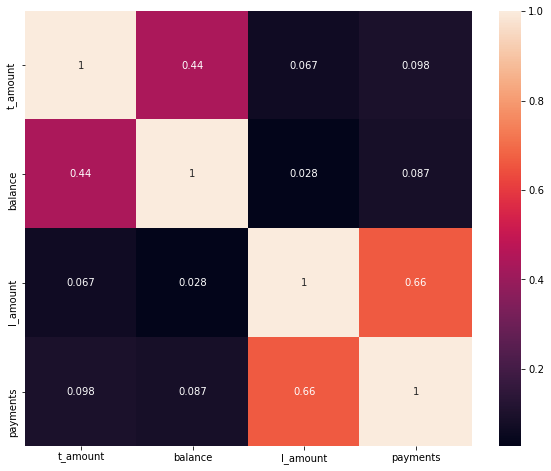

In [25]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

/Users/sabi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


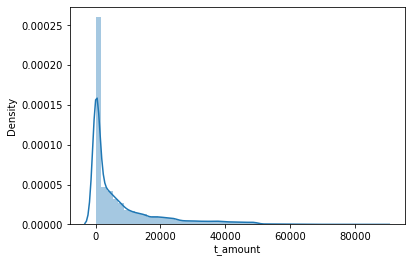

In [26]:
sns.distplot(data['t_amount'])
plt.show()

/Users/sabi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


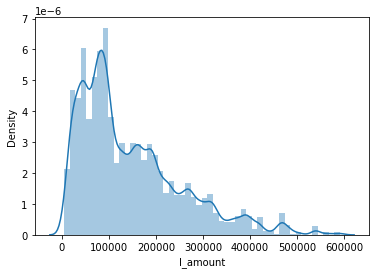

In [27]:
sns.distplot(data['l_amount'])
plt.show()

/Users/sabi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


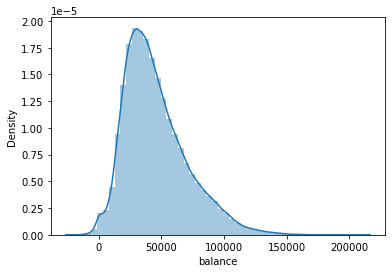

In [28]:
sns.distplot(data['balance'])
plt.show()

/Users/sabi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


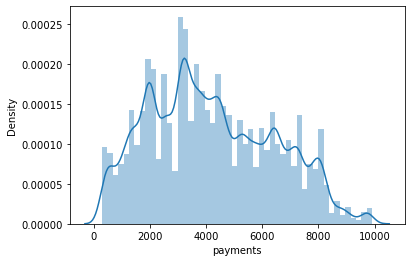

In [29]:
sns.distplot(data['payments'])
plt.show()

## Pre-processing

In [30]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

In [31]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['status'], axis=1)
categorical = pd.get_dummies(cat, columns=['type', 'operation', 'k_symbol', 'duration'])

### Train test split

In [32]:
y = data['status']
X = np.concatenate((x, categorical), axis=1)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

## Modelling

In [34]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

/Users/sabi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.7104906937394248

## Check model accuracy

In [38]:
y_test.value_counts()

C    27361
A    24614
B     3741
D     3384
Name: status, dtype: int64

In [37]:
pd.Series(predictions).value_counts()

C    29757
A    28901
B      426
D       16
dtype: int64

Qué está pasando con las diferencias?

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[19923,    92,  4599,     0],
       [ 2848,   204,   684,     5],
       [ 5441,    64, 21854,     2],
       [  689,    66,  2620,     9]])

In [41]:
classification.predict_proba(X_test)

array([[0.58040981, 0.17502742, 0.19925821, 0.04530456],
       [0.13901941, 0.00627622, 0.81786536, 0.036839  ],
       [0.88839983, 0.0179277 , 0.09212251, 0.00154996],
       ...,
       [0.03950335, 0.00681597, 0.88382334, 0.06985734],
       [0.82742746, 0.05090819, 0.11557449, 0.00608985],
       [0.48819259, 0.22716495, 0.18844204, 0.09620042]])